## Project - Recommendation System
                                                                        By: Aryan Jain

Amazon Reviews data [source](http://jmcauley.ucsd.edu/data/amazon/). The repository has several datasets. For this case study, we are using the Electronics dataset.

**Domain**: E-Commerce

**Context**: Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

**Attribute Information**
* `UserID`: Every user identified with a unique id.
* `ProductID`: Every product identified with a unique id.
* `Rating`: Rating of the corresponding product by the corresponding user.
* `timestamp`: Time of the rating.

**Learning Outcomes**
* Exploratory Data Analysis
* Creating a recommendation system using real data
* Collaborative filtering

**Objective**: Build a recommendation system to recommend products to customers based on their previous ratings for other products.

<a id='import'></a>
### Import Packages

**Need to install surprise python library before running this code**

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from surprise.model_selection import train_test_split as train_test_split_2
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import gc
%matplotlib inline

# Surprise package for making recommendation
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import GridSearchCV, cross_validate, KFold
from surprise import accuracy, Reader, Dataset, dump
from surprise import SVD

# For Sklearn NearestNeighbor based recommendation
from sklearn.metrics import pairwise_distances, mean_squared_error
from scipy.spatial.distance import correlation, cosine
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import sklearn.metrics as metrics
from math import sqrt

# Display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 20
pd.options.display.float_format = "{:.2f}".format

# Initializing a random seed for the code
np.random.seed(1)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

<a id='read'></a>
### Read and explore the dataset

In [2]:
# Reading the data as dataframe and print the first five rows
df = pd.read_csv('ratings_Electronics.csv', header = None)
df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.00,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.00,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.00,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.00,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.00,1334707200


In [3]:
# Let's set the columns headers
df.columns = ["UserID", "ItemID", "Rating", "Timestamp"]
df.head()

,UserID,ItemID,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.00,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.00,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.00,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.00,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.00,1334707200


In [4]:
# Get info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598427 entries, 0 to 6598426
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserID     object 
 1   ItemID     object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 201.4+ MB


In [5]:
# Check if there any null values in the dataframe
print("Number of missing values in each column:")
df.isnull().sum()

Number of missing values in each column:


UserID       0
ItemID       0
Rating       0
Timestamp    0
dtype: int64

In [6]:
# Check if there are any duplicate rows
print('False means no duplicates, True means there are duplicates')
df.duplicated().any()

False means no duplicates, True means there are duplicates


False

In [7]:
# Checking the uniques in `Rating` column
print('Checking the unique values in Rating column')
np.sort(df["Rating"].unique())

Checking the unique values in Rating column


array([1., 2., 3., 4., 5.])

<a id='o1'></a>
#### Observation 1 - Dataset shape
Dataset has nearly 6.6 million reviews and with information on user id, product id, rating and timestamp. There are no missing values or duplicates in the dataset. Ratings take on values from 1-5.

<a id='o2'></a>
#### Observation 2 - Information on the type of variable

* `userID`: Every user identified with a unique id (Discrete).
* `productID`: Every product identified with a unique id (Discrete).
* `Rating`: Rating of the corresponding product by the corresponding user (Categorical).
* `Timestamp`: Time of the rating (Continuous).

In [8]:
# Five point summary of numerical attributes and check unique values in 'object' columns
print("Description of all attributes")
df.describe(include = 'all')

Description of all attributes


,UserID,ItemID,Rating,Timestamp
count,6598427,6598427,6598427.00,6598427.00
unique,3674937,365051,nan,nan
top,A5JLAU2ARJ0BO,B0074BW614,nan,nan
freq,506,18244,nan,nan
mean,NaN,NaN,4.01,1328922681.83
std,NaN,NaN,1.38,71181823.52
min,NaN,NaN,1.00,1.00
25%,NaN,NaN,3.00,1301356800.00
50%,NaN,NaN,5.00,1355184000.00
75%,NaN,NaN,5.00,1377388800.00


<a id='o3'></a>
#### Observation 3 - Descriptive statistics
* **`UserID`**: object column with alphanumeric user id. Number of users in the dataset: 4201696.
* **`ProductID`**: object column with some of the product ids being numerical entries and some being alphanumerics. Numbers of rated products: 476002.
* **`Rating`**: Users have rated the products on the scale of 1 to 5.
* **`Timestamp`**: Don't think we will use this column

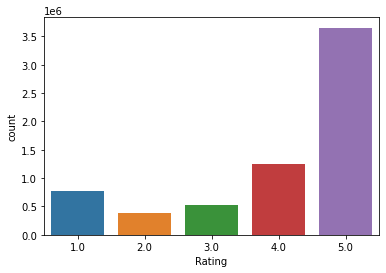

In [9]:
sns.countplot(df["Rating"]);

In [10]:
# Creating a column with the number of ratings a user gave
userid = df['UserID'].value_counts()
userid = pd.DataFrame(userid).reset_index()
userid.columns = ['UserID', 'UserIDCounts']

df = df.merge(userid, how = 'left', on = ['UserID'])

df.head()

,UserID,ItemID,Rating,Timestamp,UserIDCounts
0,AKM1MP6P0OYPR,0132793040,5.00,1365811200,2
1,A2CX7LUOHB2NDG,0321732944,5.00,1341100800,4
2,A2NWSAGRHCP8N5,0439886341,1.00,1367193600,1
3,A2WNBOD3WNDNKT,0439886341,3.00,1374451200,1
4,A1GI0U4ZRJA8WN,0439886341,1.00,1334707200,1


In [11]:
# Number of unique user id and product id in the data
print('Number of unique USERS in dataframe: ', df['UserID'].nunique())
print('Number of unique PRODUCTS in dataframe: ', df['ItemID'].nunique())

Number of unique USERS in dataframe:  3674937
Number of unique PRODUCTS in dataframe:  365051


Maximum number of rating per user is 506 and minimum is 1


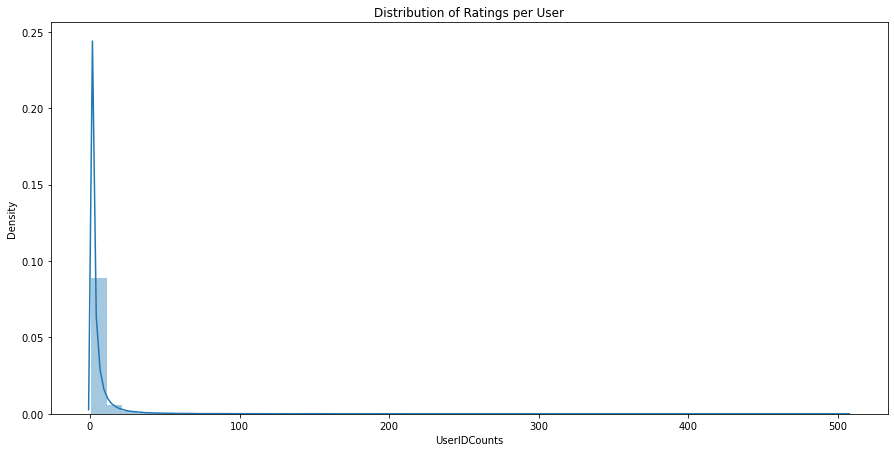

In [12]:
high = df['UserIDCounts'].max()
low = df['UserIDCounts'].min()
print(f'Maximum number of rating per user is {high} and minimum is {low}')
plt.figure(figsize = (15, 7.2))
sns.distplot(df['UserIDCounts'], bins = 50).set_title('Distribution of Ratings per User');

In [13]:
# Taking a subset of the data to make it denser
# Will only take users that have given 50 or more ratings

# Saving copy of original dataframe
df_orig = df.copy()

df = df[df['UserIDCounts'] >= 50]
print('Number of rows after filtering: {}'.format(df.shape[0]))

Number of rows after filtering: 83013


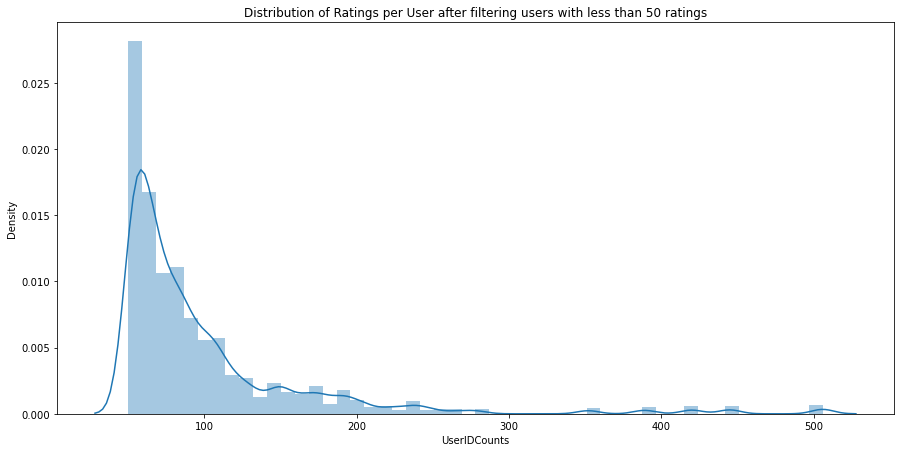

In [14]:
plt.figure(figsize = (15, 7.2))
sns.distplot(df['UserIDCounts'], bins = 50).set_title('Distribution of Ratings per User after filtering users with less than 50 ratings');

In [15]:
print('Number of product ids after filtering based on ratings given by users: {}'.format(df['ItemID'].nunique()))

Number of product ids after filtering based on ratings given by users: 36028


In [16]:
# We will now take only the UserID, ItemID and Rating columns as this is the format that the algorithms take

# Saving a copy
df_second = df.copy()

df = df[['UserID', 'ItemID', 'Rating']]

In [17]:
# Number of unique user id and product id in the data
print('Number of unique USERS and ITEM IDs in the filtered dataframe')
print('Number of unique USERS in filtered dataframe = ', df['UserID'].nunique())
print('Number of unique PRODUCTS in filtered dataframe = ', df['ItemID'].nunique())

Number of unique USERS and ITEM IDs in the filtered dataframe
Number of unique USERS in filtered dataframe =  1058
Number of unique PRODUCTS in filtered dataframe =  36028


In [18]:
# TOP and BOTTOM 10 users based on number of ratings given
print("Top 10 users: ")
top_10_users = df['UserID'].value_counts()[:10]
print(top_10_users, end="\n\n")
print("Top 10 items: ")
top_10_items = df['ItemID'].value_counts()[:10]
print(top_10_items)

Top 10 users: 
A5JLAU2ARJ0BO     506
A3OXHLG6DIBRW8    445
A6FIAB28IS79      420
ADLVFFE4VBT8      389
A680RUE1FDO8B     352
A2AY4YUOX2N1BQ    279
A1ODOGXEYECQQ8    267
A231WM2Z2JL0U3    252
A17BUUBOU0598B    244
A203OCQQ12MAVT    240
Name: UserID, dtype: int64

Top 10 items: 
B0088CJT4U    149
B003ES5ZUU    147
B000N99BBC    118
B007WTAJTO    117
B002R5AM7C    109
B00829TIEK    106
B00829THK0     96
B008DWCRQW     96
B004CLYEDC     86
B002V88HFE     84
Name: ItemID, dtype: int64


<a id='recommendations'></a>
### Recommenders
We will explore following methods of making recommendations:
* Popularity based recommendations
* Collaborative filtering (User-based and Item-based recommendations)

In [19]:
# No need to pass radom state as a parameter as we have set a constant random seed
train_data, test_data = train_test_split(df, test_size = 0.30)
train_data.shape , test_data.shape

((58109, 3), (24904, 3))

In [20]:
print('Number of unique users in training dataframe {}'.format(train_data['UserID'].nunique()))
print('Number of unique users in test dataframe: {}'.format(test_data['UserID'].nunique()))

Number of unique users in training dataframe 1058
Number of unique users in test dataframe: 1058


In [21]:
print('Number of unique products in training dataframe {}'.format(train_data['ItemID'].nunique()))
print('Number of unique products in test dataframe: {}'.format(test_data['ItemID'].nunique()))

Number of unique products in training dataframe 28391
Number of unique products in test dataframe: 15536


<a id='popularity'></a>
#### **Popularity based recommendations**
* Create a class to make recommendation using popularity based method.
* Get top 5 recommendations for couple of users, recommendations are based on the Rating means for the Product IDs. However will later explore other methods as well.
* Comment on the findings.

In [22]:
# Get list of unique user and product ids in testset
test_userids = sorted(list(test_data['UserID'].unique()))
test_productids = sorted(list(test_data['ItemID'].unique()))

### Popularity based Recommendation System

**Example:**
* `Netflix "Trending Now" section`

**Basic Concept:**
* `Based on the logic that if "many people like it, so will you"`
* `Takes the mean rating for items and recommends the ones with highest ratings`

**Advantages:**
* `No need for any data on the users`
* `Does not suffer cold start problem; it can be implemented from the minute the user creates an account`

**Disadvantages:**
* `No personization`
* `Only takes into account mean rating, not number of ratings, so if only 1 person bought the item and rated it 5 stars, it would be recommended as the best`
    * **`Possible solution: `**`take items that have been rated at least a certain number of times`
    * **`OR `**`we could sort values by mean `**`AND `**`count rather than just mean rating`
    * `Will not be implementing that in this project though`

In [23]:
def recommend(data, item_col, for_user, rating_col="Rating", top_n=5):
    grouped = data.groupby(item_col).mean()
    to_recommend = grouped.sort_values(rating_col, ascending=False).iloc[:5, :]
    print(f"Ratings for user: {for_user}")
    print("--------------------------------------------------------------", end="\n\n")
    print(to_recommend)
    return to_recommend

In [24]:
# Recommending items for a random user
popularity_recommendations = recommend(train_data, "ItemID", "A3OXHLG6DIBRW8")

Ratings for user: A3OXHLG6DIBRW8
--------------------------------------------------------------

            Rating
ItemID            
B0051V31UO    5.00
B000V1PB48    5.00
B00383HMES    5.00
B000VITZ98    5.00
B007HSKOZ4    5.00


**If we use popularity based recommendations, these will be the recommendation for every user**

In [25]:
# We can also recommend the items based on number of ratings an item got, saying that it got the most ratings,
# so it is the most popular
train_data.groupby("ItemID").count().sort_values("Rating", ascending=False).iloc[:5, :]

,UserID,Rating
ItemID,,
B003ES5ZUU,105,105
B0088CJT4U,101,101
B007WTAJTO,86,86
B000N99BBC,84,84
B002R5AM7C,75,75


**Earlier we said that popularity based recommendation systems doesn't take into account number of ratings, let's see how many ratings each the the recommendations had**

In [26]:
pop_recs = popularity_recommendations.index.tolist()
df["ItemID"].value_counts().loc[pop_recs]

B0051V31UO    1
B000V1PB48    3
B00383HMES    2
B000VITZ98    2
B007HSKOZ4    1
Name: ItemID, dtype: int64

In [27]:
# # Let's calculate RMSE for these predictions (people will rate these items as 5 stars)
# test_data.groupby("ItemID").mean()[pop_recs]

This returns an error saying that none of the recommendations were rated by any users in the test set

This just proves our point that popularity based recommendations using mean rating is not a good estimate

Let's try to use a mix of mean and count based system

In [28]:
grp_mean = train_data.groupby("ItemID").mean().sort_values("Rating", ascending=False)

In [29]:
grp_count = pd.DataFrame(train_data.groupby("ItemID").size().sort_values(ascending=False))

In [30]:
grp_mean.head(2)

,Rating
ItemID,
B0051V31UO,5.00
B000V1PB48,5.00


In [31]:
grp_count.head(2)

,0
ItemID,
B003ES5ZUU,105
B0088CJT4U,101


In [32]:
grp_mean_count = grp_mean.merge(grp_count, how="left", on="ItemID")
grp_mean_count.head()

,Rating,0
ItemID,,
B0051V31UO,5.00,1
B000V1PB48,5.00,2
B00383HMES,5.00,2
B000VITZ98,5.00,1
B007HSKOZ4,5.00,1


In [33]:
grp_mean_count.columns = ["Rating", "NumRatings"]
grp_mean_count.head()

,Rating,NumRatings
ItemID,,
B0051V31UO,5.00,1
B000V1PB48,5.00,2
B00383HMES,5.00,2
B000VITZ98,5.00,1
B007HSKOZ4,5.00,1


In [34]:
grp_mean_count.sort_values(["Rating", "NumRatings"], ascending=False, inplace=True)

In [35]:
pop_rec_mean_count = grp_mean_count.head()

In [36]:
recommendation = pop_rec_mean_count.index
grp_test = test_data.groupby("ItemID").mean()
grp_test

,Rating
ItemID,
0970407998,1.00
1400501466,5.00
1400532655,4.50
1400599997,1.00
1400698987,4.00
...,...
B009EAHVTA,5.00
B009EFY1BG,5.00
B009EIQ41I,5.00


In [37]:
recommendation

Index(['B0052SCU8U', 'B000067RT6', 'B003FVJYF8', 'B008JJLW4M', 'B000FQ2JLW'], dtype='object', name='ItemID')

In [38]:
grp_test.loc[recommendation]

,Rating
ItemID,
B0052SCU8U,5.00
B000067RT6,5.00
B003FVJYF8,5.00
B008JJLW4M,5.00
B000FQ2JLW,5.00


In [39]:
pop_rec_mean_count

,Rating,NumRatings
ItemID,,
B0052SCU8U,5.00,29
B000067RT6,5.00,20
B003FVJYF8,5.00,14
B008JJLW4M,5.00,14
B000FQ2JLW,5.00,13


<a id='o4'></a>
##### Observation 4 - Popularity Based Recommendation
* `We recommended items based on the mean rating that the item had received`
* `These gave recommendations to items nobody in the test set had rated and no more than 3 people in the training set had rated`
* `Then, instead of sorting just by mean, we sorted by both mean and number of ratings... this resulted in all 5 recommendations being rated by users in the test set`
* `All the items that were recommended got average rating as 5 in the train set and test set`
* **`This leads to an RMSE of 0`**

### Item-Based Collaborative Filtering (CF) Recommendation System

**Example:**
* `Netflix "Because you watched ..." section`

**Basic Concept:**
* `Based on the logic that if "You will like this because you liked that"`
* `Uses Singular Value Decomposition (SVD) to decompose ratings matrix and predict rating for unseen items`

**Advantages:**
* `Personalized for each user`

**Disadvantages:**
* `Suffers from cold-start problem; when a new item is uploaded, we have no idea which items are similar so we can't recommend anything`
* `Sometimes faces scalability issues when there are too many datapoints, we need to calculate too many similarities`



<a id='SVD'></a>
##### **Model based Collaborative Filtering: SVD**

In [40]:
# Creating the user-item matrix
user_item_mat = df.pivot(index = 'UserID', columns = 'ItemID', values = 'Rating').fillna(0)
user_item_mat.head()

ItemID,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B009EG1LY0,B009EIANT2,B009EIQ41I,B009EIUH6G,B009EIVSPK,B009ELOLUQ,B009EM694G,B009EMFXGQ,B009ENG6TI,B009EOJKEU
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A100WO06OQR8BQ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A105TOJ6LTVMBG,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10NMELR4KX0J6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10O7THJ2O20AG,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [41]:
# Let's try and calculate the density of our matrix

print('Shape of ratings matrix: ', user_item_mat.shape)

num_ratings = np.count_nonzero(user_item_mat)
print('Total Ratings Given: ', num_ratings)

total_pos_rats = user_item_mat.shape[0] * user_item_mat.shape[1]
print("Total Number of Ratings that could've been given: ", total_pos_rats)

density = (num_ratings/total_pos_rats)
density *= 100
print (f'Density: {round(density, 3)}')

Shape of ratings matrix:  (1058, 36028)
Total Ratings Given:  83013
Total Number of Ratings that could've been given:  38117624
Density: 0.218


In [42]:
# Singular Value Decomposition
U, sigma, Vt = svds(user_item_mat, k = 10) # decomposing the ratings matrix
sigma = np.diag(sigma) # sigma = Diagonal of sigma

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = user_item_mat.columns, index = user_item_mat.index) #predicted ratings
preds_df.head()

ItemID,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B009EG1LY0,B009EIANT2,B009EIQ41I,B009EIUH6G,B009EIVSPK,B009ELOLUQ,B009EM694G,B009EMFXGQ,B009ENG6TI,B009EOJKEU
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.00,0.02,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.00,...,0.01,0.01,0.01,0.00,0.02,0.00,0.01,0.01,0.00,-0.00
A100WO06OQR8BQ,0.00,0.00,0.01,-0.00,-0.00,0.02,-0.00,-0.01,-0.00,0.01,...,0.00,0.00,0.00,0.12,-0.00,0.01,0.01,0.00,0.01,0.04
A105TOJ6LTVMBG,0.01,-0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.01,0.00,0.00,0.00,-0.00,0.00,0.00,0.01,0.01
A10NMELR4KX0J6,0.01,-0.00,0.02,0.00,0.00,-0.00,0.00,0.01,0.00,-0.00,...,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.02
A10O7THJ2O20AG,0.02,0.00,0.02,0.01,0.01,0.00,0.00,0.01,0.01,0.00,...,0.02,0.02,0.01,0.00,0.02,-0.00,0.01,0.01,0.02,0.02


In [43]:
# Defining a function that will recommend top 5 items
def recommend_items(user_id, ratings_item, preds_df, num_recommendations = 5):
    try:
        print('User has already rated products (from data in training set): {}'.format(train_data.loc[(train_data['UserID'] == user_id), 'ProductID'].nunique()))
        print("Top 5 products from what's already being rated: {}".format(list(train_data[(train_data['UserID'] == user_id)].sort_values(by = 'Rating', ascending = False).head(5)['ProductID'])))
    except:
        print("There's no data for the selected user in training set")
    sorted_user_ratings = ratings_item.loc[user_id].sort_values(ascending = False)
    
    sorted_user_predictions = preds_df.loc[user_id].sort_values(ascending = False)
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending = False)
    print('\nTop 5 recommendations for the user based on item-based collaborative filtering method')
    display(temp.head(num_recommendations))
    return temp.head(num_recommendations).index.tolist()

In [44]:
print('Get top - K ( K = 5) recommendations.')
print('Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.'); print('--'*40)
result = {}

user_id = "A3OXHLG6DIBRW8"
print(f'\nMake recommendation for the user id selected from the testset = "{user_id}"')
result[user_id] = recommend_items(user_id, user_item_mat, preds_df)

user_id = "A10O7THJ2O20AG"
print(f'\n\nMake recommendation for the user id selected from the testset = "{user_id}"')
result[user_id] = recommend_items(user_id, user_item_mat, preds_df)

Get top - K ( K = 5) recommendations.
Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
--------------------------------------------------------------------------------

Make recommendation for the user id selected from the testset = "A3OXHLG6DIBRW8"
There's no data for the selected user in training set

Top 5 recommendations for the user based on item-based collaborative filtering method


,user_ratings,user_predictions
Recommended Items,,
B007OY5V68,0.00,0.89
B0082E9K7U,0.00,0.63
B0002CPBWI,0.00,0.62
B0063705PE,0.00,0.59
B005IMFX2K,0.00,0.57




Make recommendation for the user id selected from the testset = "A10O7THJ2O20AG"
There's no data for the selected user in training set

Top 5 recommendations for the user based on item-based collaborative filtering method


,user_ratings,user_predictions
Recommended Items,,
B003ES5ZUU,0.00,1.69
B002V88HFE,0.00,1.29
B002WE6D44,0.00,1.25
B001TH7GUU,0.00,1.18
B005HMKKH4,0.00,0.90


In [45]:
print('Evaluating SVD for Item-based Collaborative Filtering'); print('--'*60)
rmse_df = pd.concat([user_item_mat.mean(), preds_df.mean()], axis = 1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
RMSE = round((((rmse_df['Avg_actual_ratings'] - rmse_df['Avg_predicted_ratings']) ** 2).mean() ** 0.5), 4)
print('RMSE OF ITEM BASED COLLABORATIVE FILTERING USING MATRIX FACTORIZATION METHOD (SVD): {}'.format(RMSE))

Evaluating SVD for Item-based Collaborative Filtering
------------------------------------------------------------------------------------------------------------------------
RMSE OF ITEM BASED COLLABORATIVE FILTERING USING MATRIX FACTORIZATION METHOD (SVD): 0.0042


### CF USING SVD FROM SURPRISE

In [46]:
# Read the dataset
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df[['UserID','ItemID','Rating']], reader)

In [47]:
# Let's benchmark the performance for SVD and KNNWithMeans using SURPRISE

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNWithMeans()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.01,3.16,0.22
KNNWithMeans,1.11,0.08,0.44


In [48]:
# SVD using Surprise

print('Using SVD')
svd_algo = SVD()
cross_validate(svd_algo, data, measures=['RMSE'], cv=3, verbose=False)

Using SVD


{'test_rmse': array([1.00937448, 1.01839929, 1.00306406]),
 'fit_time': (3.1565959453582764, 3.2359681129455566, 3.1176061630249023),
 'test_time': (0.2376549243927002, 0.2363569736480713, 0.15402817726135254)}

In [49]:
# Split dataset for training and testing
trainset, testset = train_test_split_2(data, test_size=0.3)
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  1058 

Number of items:  28486 



In [50]:
# Train the algorithm on the training set
svd_algo.fit(trainset)

In [51]:
# test method to predict
pred_svd = svd_algo.test(testset)
pred_svd

[Prediction(uid='A2HXE29CU1I24Y', iid='B000TQU352', r_ui=4.0, est=3.9456834363622426, details={'was_impossible': False}),
 Prediction(uid='A3W4D8XOGLWUN5', iid='B000B0NC2W', r_ui=4.0, est=3.840144357332251, details={'was_impossible': False}),
 Prediction(uid='A1MZL91Z44RN06', iid='B005HMKKH4', r_ui=5.0, est=4.818582466888576, details={'was_impossible': False}),
 Prediction(uid='A3BACUOZV1M0WM', iid='B0002ZQG24', r_ui=4.0, est=4.325018485148155, details={'was_impossible': False}),
 Prediction(uid='A54S9CIUV5VNB', iid='B0009HGVZW', r_ui=5.0, est=4.551578475804958, details={'was_impossible': False}),
 Prediction(uid='ATNOI7E8GTIVE', iid='B0013IWYHU', r_ui=3.0, est=4.694956853666996, details={'was_impossible': False}),
 Prediction(uid='A20VG5W98SX99L', iid='B003IT6Z6I', r_ui=2.0, est=3.551537457446847, details={'was_impossible': False}),
 Prediction(uid='A1ZTR0FR5AW9B4', iid='B000V3NO9K', r_ui=1.0, est=3.684323536496361, details={'was_impossible': False}),
 Prediction(uid='A2RW587355CMVA',

In [52]:
# get RMSE (accuracy metric of rmse)

print('The average difference between estimated score vs. actual score:', accuracy.rmse(pred_svd, verbose=True))

RMSE: 1.0142
The average difference between estimated score vs. actual score: 1.0142164267441252


In [53]:
# function to build a pandas dataframe with all the predictions

def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

In [54]:
# df_pred_svd_sur <> df_p

df_pred_svd_sur = pd.DataFrame(pred_svd, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_pred_svd_sur['Iu'] = df_pred_svd_sur.uid.apply(get_Iu)
df_pred_svd_sur['Ui'] = df_pred_svd_sur.iid.apply(get_Ui)
df_pred_svd_sur['err'] = abs(df_pred_svd_sur.est - df_pred_svd_sur.rui)
best_predictions = df_pred_svd_sur.sort_values(by='err')[:10]
worst_predictions = df_pred_svd_sur.sort_values(by='err')[-10:]

In [55]:
print('\n------------- BEST PREDICTIONS ---------------------------------------\n')
best_predictions


------------- BEST PREDICTIONS ---------------------------------------



,uid,iid,rui,est,details,Iu,Ui,err
10868,AMFXXAOVV4CPJ,B007R5YDYA,5.00,5.00,{'was_impossible': False},33,17,0.00
15060,A1ODOGXEYECQQ8,B002EPF6YO,4.00,4.00,{'was_impossible': False},176,6,0.00
11276,A12DQZKRKTNF5E,B008N7CCJY,4.00,4.00,{'was_impossible': False},99,1,0.00
4211,A18S2VGUH9SCV5,B001MYLBJ2,4.00,4.00,{'was_impossible': False},88,0,0.00
4593,A18S2VGUH9SCV5,B005QL1H3W,4.00,4.00,{'was_impossible': False},88,0,0.00
14167,A18S2VGUH9SCV5,B005P58DEK,4.00,4.00,{'was_impossible': False},88,0,0.00
12697,A18S2VGUH9SCV5,B001VEI2OA,4.00,4.00,{'was_impossible': False},88,0,0.00
3118,A18S2VGUH9SCV5,B002RJSSOM,4.00,4.00,{'was_impossible': False},88,0,0.00
12470,A18S2VGUH9SCV5,B004AFNFZ8,4.00,4.00,{'was_impossible': False},88,0,0.00
12357,A18S2VGUH9SCV5,B001U3Y8OA,4.00,4.00,{'was_impossible': False},88,0,0.00


In [56]:
print('\n------------- WORST PREDICTIONS ---------------------------------------\n')
worst_predictions


------------- WORST PREDICTIONS ---------------------------------------



,uid,iid,rui,est,details,Iu,Ui,err
15515,AHF4I1FSIHABC,B00007E7JU,1.00,4.93,{'was_impossible': False},57,31,3.93
2122,A19XMHRB3G4DIR,B000W09ZTK,1.00,4.95,{'was_impossible': False},65,3,3.95
18016,A3EXWV8FNSSFL6,B009A6CZ30,1.00,4.96,{'was_impossible': False},130,12,3.96
6360,AT09WGFUM934H,B0001Y7UAI,1.00,4.97,{'was_impossible': False},53,12,3.97
11500,A1B8EJQU73YGL9,B00001ZWXA,1.00,5.05,{'was_impossible': False},31,7,4.05
810,A12EVK82QUTSA6,B00829TIA4,1.00,5.06,{'was_impossible': False},46,44,4.06
1270,A2AF0NOCM71J0B,B000VE2RP6,1.00,5.06,{'was_impossible': False},75,12,4.06
1174,A3NKRH3TJ4DPVI,B0018O9JIG,1.00,5.13,{'was_impossible': False},48,13,4.13
9527,A17W0GMB0YY83M,B00834SJSK,1.00,5.15,{'was_impossible': False},39,52,4.15
24814,A3F7USIDJBR8WU,B004J3V90Y,1.00,5.16,{'was_impossible': False},59,13,4.16


In [57]:
# we can now query for specific predicions
uid = 'A3OXHLG6DIBRW8'  # raw user id
iid = 'B004Q0T0LU-8520'  # raw item id
# get a prediction for specific users and items.
pred = svd_algo.predict(uid, iid, verbose=True)

user: A3OXHLG6DIBRW8 item: B004Q0T0LU-8520 r_ui = None   est = 4.39   {'was_impossible': False}


#### Item based CF using KNNWithMeans

In [58]:
# Initializing and training the model
knn_i_algo = KNNWithMeans(k=50,sim_options={'name': 'pearson_baseline', 'user_based': False})
knn_i_algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [59]:
# Predicting test set data
pred_knn_i = knn_i_algo.test(testset)
pred_knn_i

[Prediction(uid='A2HXE29CU1I24Y', iid='B000TQU352', r_ui=4.0, est=4.248360839112702, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3W4D8XOGLWUN5', iid='B000B0NC2W', r_ui=4.0, est=4.248360839112702, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1MZL91Z44RN06', iid='B005HMKKH4', r_ui=5.0, est=4.435294209822271, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A3BACUOZV1M0WM', iid='B0002ZQG24', r_ui=4.0, est=4.248360839112702, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A54S9CIUV5VNB', iid='B0009HGVZW', r_ui=5.0, est=4.666666666666667, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ATNOI7E8GTIVE', iid='B0013IWYHU', r_ui=3.0, est=4.4, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A20VG5W98SX99L', iid='B003IT6Z6I', r_ui=2.0, est=3.4285714285714284, details={'actual_k': 0, 'was_impossi

In [60]:
# get RMSE
accuracy.rmse(pred_knn_i, verbose=True)

RMSE: 1.1811


1.1810530624699442

In [61]:
# Getting the best and worst predictions
df_pred_knn_i = pd.DataFrame(pred_knn_i, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_pred_knn_i['Iu'] = df_pred_knn_i.uid.apply(get_Iu)
df_pred_knn_i['Ui'] = df_pred_knn_i.iid.apply(get_Ui)
df_pred_knn_i['err'] = abs(df_pred_knn_i.est - df_pred_knn_i.rui)
best_predictions = df_pred_knn_i.sort_values(by='err')[:10]
worst_predictions = df_pred_knn_i.sort_values(by='err')[-10:]

In [62]:
# We can now input a specific user and item and we will get a prediction
uid = 'A3J8A5L5AF5TX9'  # raw user id
iid = 'B000196C2A'  # raw item id
# get a prediction for specific users and items.
pred = knn_i_algo.predict(uid, iid, verbose=True)

user: A3J8A5L5AF5TX9 item: B000196C2A r_ui = None   est = 4.00   {'actual_k': 0, 'was_impossible': False}


In [63]:
## Step 1: Load the dataset
## Already done in earlier steps, so am commenting the code

# data = Dataset.load_from_df(df[['author','product','score']], reader)

In [64]:
# Step 2: Build a training set


trainsetfull = data.build_full_trainset()

print('Number of users: ', trainsetfull.n_users, '\n')
print('Number of items: ', trainsetfull.n_items, '\n')


Number of users:  1058 

Number of items:  36028 



In [65]:
# Step 3:
# Cross-Validation

algo = KNNWithMeans(k=50,sim_options={'name': 'cosine', 'user_based': False})

results = cross_validate(algo = algo, data = data, measures=['RMSE'], cv=3, return_train_measures=True, verbose=False)   
print(results['test_rmse'].mean())

# Model Training
algo.fit(trainsetfull)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
1.1817561386549749
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [66]:
# Let's predict score for a random user & product

uid = 'A3J8A5L5AF5TX9' 
iid = 'B000196C2A'  
prediction = algo.predict(uid,iid,verbose=True)

user: A3J8A5L5AF5TX9 item: B000196C2A r_ui = None   est = 4.43   {'actual_k': 4, 'was_impossible': False}


In [67]:
# Testing the model

# Building a test set
testset = trainset.build_anti_testset()

# Predicting ratigns for users and items in test set

test_pred = algo.test(testset)
test_pred

[Prediction(uid='A34UVV757IKPVB', iid='B00009R6AV', r_ui=4.248360839112702, est=5.230769230769231, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A34UVV757IKPVB', iid='B001VTPENM', r_ui=4.248360839112702, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A34UVV757IKPVB', iid='B000HJ5N2Y', r_ui=4.248360839112702, est=4.028022964413718, details={'actual_k': 9, 'was_impossible': False}),
 Prediction(uid='A34UVV757IKPVB', iid='B003EEK03Q', r_ui=4.248360839112702, est=3.071428571428571, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A34UVV757IKPVB', iid='B001NS0OZ4', r_ui=4.248360839112702, est=4.22487012987013, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid='A34UVV757IKPVB', iid='B00007E7JU', r_ui=4.248360839112702, est=4.129885272330775, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid='A34UVV757IKPVB', iid='B000GR3XFQ', r_ui=4.248360839112702, est=3.0740740740740744, details={'actu

In [68]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1121


1.1121494673155652

In [69]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """
    Return the top-N recommendations for each user from a set of predictions.

    Parameters:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [70]:
top_n = get_top_n(test_pred, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A34UVV757IKPVB ['B004PDZ6T8', 'B00008VFBE', 'B002ROHZ50', 'B00002N7K8', 'B004H1RTMK']
A15Q2L6DYRTFIU ['B003U7RM9M', 'B0051GN8JI', 'B002W0N7VA', 'B000EPNES6', 'B0057YRJNK']
AOEAD7DPLZE53 ['B003QSJTZA', 'B0009K9Q1A', 'B003UGGB7W', 'B004CJ8ZIO', 'B000EVS4YY']
A2FSOHSM9X13JT ['B004YEZGIO', 'B0046TT9A8', 'B001DDW9V6', 'B0039SM0AS', 'B00425S1H8']
A2KIJBT9HRIOM8 ['B000JO1IPI', 'B001TH7FAQ', 'B000B8IHDS', 'B005LCTOT0', 'B0043G7GHW']
AP53MVRC8ZEW2 ['B006FKRSUY', 'B00284AMZO', 'B0014175OI', 'B002V1F5FQ', 'B0006LSIJS']
AMVXR3NPL0GWX ['B000NAXC6Q', 'B0001DHHIY', 'B0010DJZBQ', 'B0009XQPHU', 'B0041G633W']
A2J8T58Z4X15IO ['B0001YXWLE', 'B0000A55BE', 'B00022AH6I', 'B000J424AG', 'B0001NBG54']
A3MQAQT8C6D1I7 ['B0010DJZBQ', 'B0099PJE7W', 'B001VLF4RG', 'B005T3GPXE', 'B0017LZIRQ']
A3Q4TYJVAM4IRM ['B000E5RJJQ', 'B0013HHDH2', 'B000MWVMRG', 'B00066EK36', 'B00004RC2G']
A1OO9N1MRNQ7K0 ['B000N19CV4', 'B00005T387', 'B00066Z9XG', 'B0002BBQKK', 'B001RNOHL2']
A3F7F7QKQP2FKT ['B000BOLHH0', 'B001OBSKPG', 'B001N3OV8K',

<a id='conclusion'></a>
### Conclusion

* **`Cold Start Problem: `**`When a new user creates an account or a new item is uploaded and we don't have enough information to make recommendations`


* **`Gray Sheep Problem: `**`Users that have unique tastes that differ from the majority of the population. This can be a problem with non-personalized recommendations`


* `Non-personalized recommendations (like the ones in popularity based system) are generated by averaging all the rating to every product and sorting them... here we recommended the top 5 products and got an RMSE of 0, though this will rarely happen due to gray sheep problem`


* `Collaborative Filtering system is personalized as the recommendations change based on the target user... when we applied it with SVD from scratch, we got an RMSE of 0.0042`

* `When we applied it with SVD from surprise, we got an RMSE of 1.0142`

* `The kNNWithMeans algorithm provides a collaborative filtering system that's based on the kNN algorithm... when we applied this, we scored an RMSE of 1.1121`


* `Items that have received many ratings get recommended alot (higher chance to be similar to another item) whereas items with few ratings very rarely get recommended`


* `Popularity based system avoids cold start problem but faces gray sheep problem`


* `Collaborative Filtering avoids gray sheep problem but faces cold start problem`


* `To avoid both of these issues, we can build a hybrid recommendation system that uses popularity based in the beginning but then once we get enough information on the user, switches to collaborative filtering`


* `In this project, `**`Popularity based recommendation`**` system scored the best with an RMSE of 0... this is because every rating that the best 5 items got were 5 stars, in the train as well as test set. This system performed so well because, in this dataset, there were no gray sheep`


* `If we were to implement a system on an actual website though, I would use the `**`Collaborative Filtering with SVD`**` that we built from scratch.. this is because the RMSE is nearly 0, `**`AND `**`it provides personalization for every user`